In [1]:
import sys 
sys.path.append('../..')
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
import numpy as np
import torch as ch
from torch import Tensor
import torch.nn as nn
from torch.distributions import Gumbel, Uniform
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import datetime

## Default Experiment Parameters

In [108]:
# procedure hyperparameters
args = Parameters({ 
    'epochs': 25,
    'num_workers': 0, 
    'batch_size': 100,
    'bias': True,
    'num_samples': 10,
    'clamp': True, 
    'radius': 5.0, 
    'var_lr': 1e-2,
    'lr': 1e-1,
    'shuffle': False, 
    'tol': 1e-2,
    'samples': 10000,  # number of samples to generate for ground truth
    'in_features': 2, # number of in-features to multi-log-reg
    'k': 2, # number of classes
    'lower': -1, # lower bound for generating ground truth weights
    'upper': 1,  # upper bound for generating ground truth weights
    'custom_criterion': F.gumbel_softmax,
    'trials': 10,
})

# Generate Synthetic Data

In [37]:
# generate ground-truth from uniform distribution
U = Uniform(args.lower, args.upper)
ground_truth = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)
ground_truth.weight = nn.Parameter(U.sample(ch.Size([args.K, args.IN_FEATURES])))
if ground_truth.bias is not None: 
    ground_truth.bias = nn.Parameter(U.sample(ch.Size([args.K,])))
print("ground truth weights: {}".format(ground_truth.weight))
print("ground truth bias: {}".format(ground_truth.bias))
# independent variable 
U_ = Uniform(-5, 5)
X = U_.sample(ch.Size([args.samples, args.IN_FEATURES]))
# determine base model logits 
z = ground_truth(X)
# apply softmax to unnormalized likelihoods
y = ch.argmax(ch.nn.Softmax(dim=1)(z), dim=1)

ground truth weights: Parameter containing:
tensor([[ 0.1325,  0.7295],
        [-0.1977,  0.4415]], requires_grad=True)
ground truth bias: Parameter containing:
tensor([-0.5368, -0.3590], requires_grad=True)


# Algorithm Parameters

In [156]:
# all synthetic data 
ds = TensorDataset(X, y)
# split ds into training and validation data sets
train_length = int(len(ds)*.8)
val_length = len(ds) - train_length
train_ds, val_ds = ch.utils.data.random_split(ds, [train_length, val_length])
# train and validation loaders
train_loader = DataLoader(train_ds, num_workers=args.num_workers, batch_size=args.batch_size)
val_loader = DataLoader(val_ds, num_workers=args.num_workers, batch_size=args.batch_size)
# gradients
gumbel_ce = GumbelCE.apply
ce_loss = nn.CrossEntropyLoss()

# PyTorch CE Loss

In [295]:
# CE LOSS TABLE FOR METRICS
CE_LOSS_TABLE_NAME = 'ce_loss'

STORE_PATH = '/home/pstefanou/MultinomialLogisticRegression'
store = Store(STORE_PATH)

store.add_table(CE_LOSS_TABLE_NAME, { 
    'train_acc': float, 
    'val_acc': float, 
    'train_loss': float, 
    'val_loss': float,
    'epoch': int,
})

Logging in: /home/pstefanou/MultinomialLogisticRegression/9b8828df-1f70-4d59-8592-a8f7bf5f4aac


In [296]:
multi_log_reg = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)
# optimizer and scheduler
optimizer = ch.optim.SGD(multi_log_reg.parameters(), lr=1e-1)
scheduler = ch.optim.lr_scheduler.CosineAnnealingLR(optimizer, args.epochs)

for i in range(args.trials):
    for epoch in range(args.epochs): 
        # train loop
        train_loss, train_acc = Tensor([]), Tensor([])
        for batch_X, batch_y in train_loader: 
            optimizer.zero_grad()
            pred = multi_log_reg(batch_X)
            loss = ce_loss(pred,  batch_y)
            loss.backward()
            optimizer.step()
            scheduler.step()
            # keep track of algorithm training loss and accuracy
            acc = (ch.argmax(ch.nn.Softmax(dim=1)(pred), dim=1) == batch_y).sum() / batch_y.size(0)
            train_loss = ch.cat([train_loss, Tensor([loss])]) if train_loss.size() != ch.Size([0]) else Tensor([loss])
            train_acc = ch.cat([train_acc, Tensor([acc])]) if train_acc.size() != ch.Size([0]) else Tensor([acc])
        # validation loop
        val_loss, val_acc = Tensor([]), Tensor([])
        with ch.no_grad(): 
            for batch_X, batch_y in val_loader: 
                pred = multi_log_reg(batch_X)
                loss = ce_loss(pred, batch_y)
                # keep track of algorithm validation loss and accuracy
                acc = (ch.argmax(ch.nn.Softmax(dim=1)(pred), dim=1) == batch_y).sum() / batch_y.size(0)            
                val_loss = ch.cat([val_loss, Tensor([loss])]) if val_loss.size() != ch.Size([0]) else Tensor([loss])
                val_acc = ch.cat([val_acc, Tensor([acc])]) if val_acc.size() != ch.Size([0]) else Tensor([acc])

        store[CE_LOSS_TABLE_NAME].append_row({ 
            'train_acc': float(train_acc.mean()), 
            'val_acc': float(val_acc.mean()), 
            'train_loss': float(train_loss.mean()), 
            'val_loss': float(val_loss.mean()),
            'epoch': int(epoch + 1),
        })
store.close()

# Read Results Experiment

In [297]:
reader = CollectionReader(STORE_PATH)
results = reader.df(CE_LOSS_TABLE_NAME)
reader.close() # close reader
results.head()

100%|██████████| 1/1 [00:00<00:00, 136.53it/s]


,train_acc,val_acc,train_loss,val_loss,epoch,exp_id
0,0.905375,0.9655,0.247662,0.134356,1,9b8828df-1f70-4d59-8592-a8f7bf5f4aac
1,0.972625,0.9825,0.119914,0.098980,2,9b8828df-1f70-4d59-8592-a8f7bf5f4aac
2,0.986625,0.9880,0.097408,0.087487,3,9b8828df-1f70-4d59-8592-a8f7bf5f4aac
3,0.990625,0.9920,0.086181,0.077488,4,9b8828df-1f70-4d59-8592-a8f7bf5f4aac
4,0.993750,0.9945,0.078955,0.072315,5,9b8828df-1f70-4d59-8592-a8f7bf5f4aac


# Plot Loss and Accuracy Curves

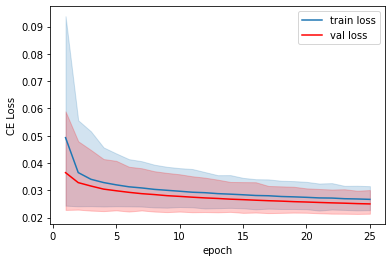

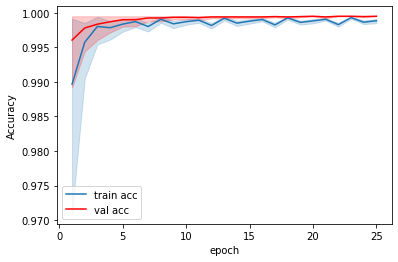

In [299]:
sns.lineplot(data=results, x='epoch', y='train_loss', label='train loss')
ax = sns.lineplot(data=results, x='epoch', y='val_loss', color='red', label='val loss')
ax.set(xlabel='epoch', ylabel='CE Loss')
plt.show()

sns.lineplot(data=results, x='epoch', y='train_acc', label='train acc')
ax = sns.lineplot(data=results, x='epoch', y='val_acc', color='red', label='val acc')
ax.set(xlabel='epoch', ylabel='Accuracy')
plt.show()

# CE Latent Variable Model Loss

In [162]:
gumbel = Gumbel(0, 1)

class GumbelCE(ch.autograd.Function):
    @staticmethod
    def forward(ctx, pred, targ):
        ctx.save_for_backward(pred, targ)
        loss = ch.nn.CrossEntropyLoss()
        return loss(pred, targ)

    @staticmethod
    def backward(ctx, grad_output):
        pred, targ = ctx.saved_tensors
        # make num_samples copies of pred logits
        stacked = pred[None, ...].repeat(args.num_samples, 1, 1)        
        # add gumbel noise to logits
        noised = stacked + gumbel.sample(stacked.size())
        print("noised: {}".format(noised))
        # remove noisy logits that fall below z_k
        for i in range(noised.size(1)): # iterate over samples within batch
            # get minimum noisy logit for kth class
            z_k_min = ch.min(noised[:, i, int(targ[i])])
            # remove logits that are strictly larger than z_k_min
            for j in range(noised.size(2)):
                if j != targ[i]: 
                    values = noised[:, i, int(j)]
                    noised[:, i, int(j)] = ch.where(values > z_k_min, ch.zeros(1), values)  

        out = noised.sum(dim = 0) / (noised.count_nonzero(dim=0) + 1e-5)
        # calculate gradient 
        grad = (1 - ch.exp(-out))
        print("avg grad: {}".format(grad / pred.size(0)))
        return grad / pred.size(0), None

In [163]:
# CE LOSS TABLE FOR METRICS
LATENT_CE_TABLE_NAME = 'latent_ce_grad'

STORE_PATH = '/home/pstefanou/MultinomialLogisticRegression'
store = Store(STORE_PATH)

store.add_table(LATENT_CE_TABLE_NAME, { 
    'train_acc': float, 
    'val_acc': float, 
    'train_loss': float, 
    'val_loss': float,
    'epoch': int,
})

Logging in: /home/pstefanou/MultinomialLogisticRegression/8f9cedfb-00da-4086-99d4-f9cca5a8f3c6


In [ ]:
multi_log_reg = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)
# optimizer and scheduler
optimizer = ch.optim.SGD(multi_log_reg.parameters(), lr=1e-1)
scheduler = ch.optim.lr_scheduler.CosineAnnealingLR(optimizer, args.epochs)

# for i in range(args.trials):
for epoch in range(args.epochs): 
    # train loop
    train_loss, train_acc = Tensor([]), Tensor([])
    for batch_X, batch_y in train_loader: 
        optimizer.zero_grad()
        pred = multi_log_reg(batch_X)
        loss = GumbelCE.apply(pred,  batch_y)
        loss.backward()
        optimizer.step()
        scheduler.step()
        # keep track of algorithm training loss and accuracy
        acc = (ch.argmax(ch.nn.Softmax(dim=1)(pred), dim=1) == batch_y).sum() / batch_y.size(0)
        train_loss = ch.cat([train_loss, Tensor([loss])]) if train_loss.size() != ch.Size([0]) else Tensor([loss])
        train_acc = ch.cat([train_acc, Tensor([acc])]) if train_acc.size() != ch.Size([0]) else Tensor([acc])
    # validation loop
    val_loss, val_acc = Tensor([]), Tensor([])
    with ch.no_grad(): 
        for batch_X, batch_y in val_loader: 
            pred = multi_log_reg(batch_X)
            loss = gumbel_ce(pred, batch_y)
            # keep track of algorithm validation loss and accuracy
            acc = (ch.argmax(ch.nn.Softmax(dim=1)(pred), dim=1) == batch_y).sum() / batch_y.size(0)            
            val_loss = ch.cat([val_loss, Tensor([loss])]) if val_loss.size() != ch.Size([0]) else Tensor([loss])
            val_acc = ch.cat([val_acc, Tensor([acc])]) if val_acc.size() != ch.Size([0]) else Tensor([acc])

    store[LATENT_CE_TABLE_NAME].append_row({ 
        'train_acc': float(train_acc.mean()), 
        'val_acc': float(val_acc.mean()), 
        'train_loss': float(train_loss.mean()), 
        'val_loss': float(val_loss.mean()),
        'epoch': int(epoch + 1),
    })
store.close()

noised: tensor([[[ 0.6404,  2.0922],
         [ 0.6562,  1.8840],
         [-0.3383, -1.3069],
         ...,
         [ 0.2319, -2.1883],
         [-0.4827, -0.7199],
         [-1.3630,  1.0489]],

        [[ 1.5285, -1.5223],
         [ 0.3857, -1.5736],
         [-0.4137,  1.4432],
         ...,
         [-0.0530, -0.6451],
         [ 1.9648, -1.2050],
         [-1.8579, -0.0077]],

        [[ 3.1201,  2.9066],
         [ 0.0764,  0.7568],
         [ 1.0517,  1.3482],
         ...,
         [-1.1155, -0.9080],
         [-0.5287,  0.4352],
         [-2.9258, -1.3117]],

        ...,

        [[ 1.4124, -1.3342],
         [-0.2050, -0.2074],
         [-0.0148, -0.5498],
         ...,
         [-1.2369, -0.6625],
         [-0.9076,  0.0057],
         [-0.5798, -1.3422]],

        [[ 0.6898, -1.2129],
         [ 1.2498, -1.5640],
         [-0.0690,  0.1348],
         ...,
         [ 0.0157, -1.5223],
         [-1.9917, -0.3383],
         [-1.3168, -0.1791]],

        [[ 0.8203, -0.0673],

avg grad: tensor([[ 0.0000, -0.0045],
        [-0.0021,  0.0000],
        [ 0.0000,  0.0020],
        [ 0.0033, -0.0164],
        [ 0.0000,  0.0019],
        [ 0.0026,  0.0000],
        [-0.0325,  0.0033],
        [ 0.0000,  0.0029],
        [ 0.0000, -0.0016],
        [-0.0048,  0.0000],
        [ 0.0049,  0.0000],
        [ 0.0000, -0.0055],
        [ 0.0000,  0.0042],
        [ 0.0057,  0.0000],
        [-0.0141,  0.0000],
        [-0.0092,  0.0000],
        [ 0.0022,  0.0000],
        [ 0.0060,  0.0000],
        [-0.0039,  0.0000],
        [ 0.0000,  0.0043],
        [ 0.0000, -0.0069],
        [ 0.0000,  0.0026],
        [ 0.0020,  0.0000],
        [ 0.0000,  0.0044],
        [ 0.0053, -0.0112],
        [ 0.0067,  0.0000],
        [ 0.0031,  0.0000],
        [ 0.0000,  0.0031],
        [ 0.0000,  0.0073],
        [ 0.0000,  0.0026],
        [ 0.0075, -0.0292],
        [ 0.0000, -0.0022],
        [ 0.0060, -0.0138],
        [ 0.0039,  0.0000],
        [ 0.0000, -0.0025],
        [-

avg grad: tensor([[-0.0175,  0.0035],
        [-0.0006, -0.0108],
        [ 0.0067, -0.0345],
        [ 0.0039,  0.0000],
        [ 0.0032, -0.0244],
        [ 0.0000,  0.0054],
        [ 0.0002,  0.0000],
        [-0.0086,  0.0030],
        [ 0.0032,  0.0000],
        [ 0.0000,  0.0018],
        [ 0.0046, -0.0105],
        [ 0.0000, -0.0119],
        [ 0.0000,  0.0002],
        [ 0.0054,  0.0000],
        [ 0.0000,  0.0017],
        [ 0.0000, -0.0030],
        [ 0.0044,  0.0000],
        [-0.0017,  0.0000],
        [ 0.0032,  0.0000],
        [ 0.0000,  0.0014],
        [-0.0044,  0.0000],
        [ 0.0000, -0.0020],
        [ 0.0000,  0.0067],
        [ 0.0030,  0.0000],
        [ 0.0042, -0.0105],
        [ 0.0030,  0.0000],
        [ 0.0000, -0.0004],
        [-0.0098,  0.0042],
        [ 0.0037, -0.0393],
        [ 0.0000, -0.0043],
        [-0.0015,  0.0000],
        [ 0.0000, -0.0035],
        [-0.0023,  0.0000],
        [ 0.0065, -0.0025],
        [ 0.0048, -0.0161],
        [-

avg grad: tensor([[-1.4185e-03,  0.0000e+00],
        [ 6.8515e-03, -9.5011e-03],
        [ 0.0000e+00,  6.2097e-04],
        [ 0.0000e+00,  4.8930e-03],
        [ 0.0000e+00,  1.8022e-03],
        [ 0.0000e+00,  2.8144e-03],
        [ 0.0000e+00, -1.7377e-03],
        [ 5.8906e-03, -2.1337e-02],
        [ 7.9135e-03, -1.4947e-02],
        [ 0.0000e+00, -1.2076e-03],
        [ 2.9300e-03, -2.6465e-02],
        [ 5.4643e-03, -2.6261e-02],
        [ 0.0000e+00, -2.6202e-04],
        [-9.3780e-03,  0.0000e+00],
        [ 0.0000e+00,  2.1106e-03],
        [ 0.0000e+00, -1.1917e-02],
        [ 0.0000e+00, -6.8803e-03],
        [ 4.8736e-03,  0.0000e+00],
        [-3.1141e-02,  5.4104e-03],
        [ 6.8057e-03,  0.0000e+00],
        [ 2.6925e-03,  0.0000e+00],
        [ 0.0000e+00,  2.5702e-03],
        [ 0.0000e+00, -8.9019e-03],
        [ 0.0000e+00,  9.9584e-04],
        [ 0.0000e+00,  5.3136e-03],
        [ 1.7042e-03,  0.0000e+00],
        [ 0.0000e+00,  3.1964e-03],
        [-2.1979e-

avg grad: tensor([[ 0.0055, -0.0287],
        [ 0.0000,  0.0028],
        [ 0.0000,  0.0057],
        [ 0.0000, -0.0031],
        [ 0.0000, -0.0068],
        [ 0.0000,  0.0006],
        [ 0.0000, -0.0019],
        [ 0.0000,  0.0040],
        [ 0.0037,  0.0000],
        [ 0.0000, -0.0101],
        [-0.0005,  0.0000],
        [ 0.0000,  0.0044],
        [-0.0064, -0.0278],
        [ 0.0015,  0.0000],
        [ 0.0000,  0.0052],
        [ 0.0048,  0.0000],
        [ 0.0023,  0.0000],
        [ 0.0000,  0.0078],
        [ 0.0034,  0.0000],
        [ 0.0066, -0.0052],
        [ 0.0000,  0.0041],
        [ 0.0005,  0.0000],
        [-0.0121,  0.0067],
        [ 0.0000,  0.0009],
        [ 0.0000,  0.0027],
        [ 0.0000, -0.0007],
        [ 0.0022,  0.0000],
        [ 0.0017,  0.0000],
        [-0.0236,  0.0018],
        [ 0.0011,  0.0000],
        [ 0.0007,  0.0000],
        [ 0.0056,  0.0000],
        [ 0.0000,  0.0031],
        [ 0.0000, -0.0058],
        [-0.0009,  0.0000],
        [ 

avg grad: tensor([[ 0.0000e+00,  5.0140e-03],
        [-3.0767e-03,  0.0000e+00],
        [ 2.2871e-04,  0.0000e+00],
        [ 0.0000e+00,  2.4092e-03],
        [ 0.0000e+00, -3.1658e-03],
        [ 0.0000e+00, -5.6095e-04],
        [-1.2279e-04,  0.0000e+00],
        [ 1.9181e-03,  0.0000e+00],
        [-3.2912e-03,  0.0000e+00],
        [ 0.0000e+00, -6.2449e-03],
        [ 0.0000e+00,  3.2934e-03],
        [ 0.0000e+00, -3.1890e-03],
        [ 0.0000e+00,  5.1231e-03],
        [-1.1580e-02,  0.0000e+00],
        [-8.4655e-03,  0.0000e+00],
        [-1.0680e-02,  0.0000e+00],
        [ 0.0000e+00, -2.2689e-03],
        [ 0.0000e+00,  2.9344e-03],
        [ 0.0000e+00,  2.0478e-03],
        [ 0.0000e+00,  4.5477e-03],
        [ 0.0000e+00,  6.4210e-03],
        [ 1.5799e-03,  0.0000e+00],
        [ 2.5283e-03,  0.0000e+00],
        [ 0.0000e+00, -4.0884e-05],
        [ 0.0000e+00,  2.4107e-03],
        [ 0.0000e+00,  7.7256e-04],
        [-2.2977e-02,  0.0000e+00],
        [ 5.1650e-

noised: tensor([[[ 2.8313e-01,  3.9497e-01],
         [ 9.8091e-02,  1.5756e+00],
         [ 7.9459e-01, -8.9904e-01],
         ...,
         [ 1.1277e-01,  9.5761e-01],
         [ 8.1463e-01,  4.3875e-01],
         [ 1.0116e+00, -1.6563e+00]],

        [[ 5.8144e-01,  4.8004e-02],
         [ 1.1677e+00, -1.0938e+00],
         [ 3.2638e+00,  4.2725e-01],
         ...,
         [-1.3647e+00,  1.3794e+00],
         [-5.5022e-01,  1.2087e+00],
         [ 7.8922e-01, -4.6635e-01]],

        [[ 5.7906e-01,  1.6470e-02],
         [-1.2198e+00,  2.7027e-01],
         [ 2.5966e+00,  9.4186e-01],
         ...,
         [-1.6976e+00,  2.3128e+00],
         [ 5.2941e-01,  2.6993e-02],
         [ 4.5703e-01, -1.3533e+00]],

        ...,

        [[ 1.0325e+00,  3.0265e-01],
         [ 4.5526e-01,  1.1672e+00],
         [-1.3460e-01,  1.3451e+00],
         ...,
         [-5.9198e-01,  1.1522e+00],
         [ 6.3774e-01,  3.3695e-01],
         [ 5.7413e-02,  3.2687e+00]],

        [[ 2.6894e+00,  1.

avg grad: tensor([[ 0.0000e+00,  2.7655e-03],
        [ 1.2249e-03,  0.0000e+00],
        [ 0.0000e+00,  1.3128e-03],
        [ 5.2577e-03,  0.0000e+00],
        [-3.9723e-03,  6.0365e-03],
        [ 2.7149e-03,  0.0000e+00],
        [ 0.0000e+00,  1.3588e-03],
        [ 0.0000e+00,  3.6588e-03],
        [ 0.0000e+00,  2.7879e-03],
        [ 4.3972e-03,  0.0000e+00],
        [ 2.6080e-03,  0.0000e+00],
        [ 0.0000e+00,  2.9692e-03],
        [ 0.0000e+00,  3.7887e-03],
        [ 3.8119e-03,  0.0000e+00],
        [-9.6777e-03,  0.0000e+00],
        [-6.2356e-03,  0.0000e+00],
        [ 1.5057e-03,  0.0000e+00],
        [-9.7644e-05,  0.0000e+00],
        [-7.4744e-04,  0.0000e+00],
        [ 0.0000e+00,  2.1895e-03],
        [ 0.0000e+00,  9.7587e-04],
        [ 0.0000e+00,  2.5189e-04],
        [ 6.1640e-04,  0.0000e+00],
        [ 0.0000e+00,  4.9331e-03],
        [ 2.3674e-03,  0.0000e+00],
        [ 3.9311e-03,  0.0000e+00],
        [ 4.7372e-03, -6.6242e-03],
        [ 0.0000e+

avg grad: tensor([[ 0.0000e+00,  2.7951e-03],
        [ 4.7362e-03,  0.0000e+00],
        [ 4.0258e-03, -2.2802e-02],
        [ 5.9399e-03,  0.0000e+00],
        [ 6.0676e-03, -6.6606e-03],
        [ 0.0000e+00,  3.9129e-03],
        [ 1.8327e-03,  0.0000e+00],
        [ 0.0000e+00, -2.3174e-03],
        [ 7.2160e-04,  0.0000e+00],
        [-2.1400e-02,  6.1252e-03],
        [ 7.5733e-03, -6.7227e-03],
        [ 0.0000e+00, -3.8230e-03],
        [ 0.0000e+00,  5.1765e-03],
        [-1.8802e-02,  0.0000e+00],
        [ 0.0000e+00,  3.6905e-03],
        [ 0.0000e+00,  7.6052e-04],
        [ 6.3950e-03,  0.0000e+00],
        [ 1.2341e-03,  0.0000e+00],
        [ 8.2454e-03, -6.0399e-03],
        [ 0.0000e+00, -5.2719e-03],
        [ 3.4351e-03,  0.0000e+00],
        [ 0.0000e+00, -2.8159e-03],
        [-9.0800e-03,  5.9144e-03],
        [ 3.4366e-03,  0.0000e+00],
        [ 6.9674e-03, -8.8027e-03],
        [-5.2071e-03,  0.0000e+00],
        [ 0.0000e+00,  5.8085e-03],
        [ 0.0000e+

noised: tensor([[[-9.1356e-01,  1.2448e+00],
         [ 2.6115e+00,  4.5364e-01],
         [-2.5097e-03, -7.6828e-01],
         ...,
         [ 2.7653e+00,  6.1557e-01],
         [ 3.0017e-01, -4.9143e-01],
         [ 5.3246e+00, -1.0084e+00]],

        [[-2.0480e+00,  3.3012e+00],
         [ 3.6880e-01,  9.5174e-01],
         [ 9.3675e-01,  1.3513e+00],
         ...,
         [ 1.1879e+00,  1.0878e+00],
         [-4.6705e-01,  1.1675e+00],
         [ 1.4971e+00,  3.0991e-01]],

        [[-3.7446e-01,  2.2099e+00],
         [ 1.3931e+00,  3.8308e-01],
         [ 4.9817e-02,  1.4498e+00],
         ...,
         [ 6.5966e-01, -8.8026e-01],
         [ 7.7470e-02,  2.9006e+00],
         [ 3.4028e+00, -8.7936e-01]],

        ...,

        [[-1.2315e+00,  1.0127e+00],
         [ 1.5871e+00, -6.4369e-01],
         [ 3.8532e+00,  3.1992e+00],
         ...,
         [ 2.7354e+00, -1.1107e+00],
         [-1.0181e-01,  3.0401e-01],
         [ 2.9299e+00, -1.3085e+00]],

        [[-1.3076e+00,  1.

avg grad: tensor([[-3.7748e-02,  5.6068e-03],
        [ 1.6333e-03,  0.0000e+00],
        [ 3.6816e-03, -1.6174e-02],
        [ 0.0000e+00,  3.0634e-03],
        [-1.0138e-03,  0.0000e+00],
        [ 1.1736e-05,  0.0000e+00],
        [ 0.0000e+00,  5.2999e-03],
        [ 0.0000e+00,  5.5596e-03],
        [ 0.0000e+00,  1.0919e-03],
        [ 0.0000e+00,  2.8576e-03],
        [ 0.0000e+00,  7.4223e-03],
        [ 0.0000e+00,  2.2600e-03],
        [ 4.0972e-03, -2.9246e-02],
        [ 0.0000e+00,  4.9716e-03],
        [ 0.0000e+00,  3.8535e-03],
        [ 0.0000e+00,  3.0524e-03],
        [-7.7223e-04,  0.0000e+00],
        [ 0.0000e+00,  3.6708e-03],
        [ 2.8168e-03,  0.0000e+00],
        [ 0.0000e+00,  5.1613e-03],
        [-1.3149e-03,  0.0000e+00],
        [ 0.0000e+00, -5.2049e-03],
        [ 4.2415e-04,  0.0000e+00],
        [ 3.8599e-03,  0.0000e+00],
        [ 6.0324e-03, -7.2135e-04],
        [ 5.6112e-03,  0.0000e+00],
        [ 0.0000e+00,  3.2699e-03],
        [ 0.0000e+

avg grad: tensor([[ 0.0002,  0.0000],
        [ 0.0000,  0.0035],
        [ 0.0009,  0.0000],
        [ 0.0070,  0.0000],
        [ 0.0040, -0.0092],
        [ 0.0000, -0.0035],
        [ 0.0000,  0.0058],
        [-0.0037,  0.0000],
        [ 0.0000,  0.0007],
        [ 0.0000,  0.0049],
        [ 0.0000, -0.0023],
        [ 0.0000, -0.0001],
        [ 0.0036,  0.0000],
        [-0.0059,  0.0000],
        [ 0.0000, -0.0010],
        [ 0.0000, -0.0031],
        [ 0.0000,  0.0036],
        [ 0.0000,  0.0063],
        [ 0.0086, -0.0083],
        [ 0.0056,  0.0000],
        [-0.0049,  0.0000],
        [ 0.0074, -0.0158],
        [ 0.0000, -0.0014],
        [-0.0015,  0.0000],
        [ 0.0030,  0.0000],
        [ 0.0064, -0.0200],
        [ 0.0000, -0.0010],
        [ 0.0000,  0.0071],
        [ 0.0000,  0.0054],
        [ 0.0000,  0.0062],
        [ 0.0000, -0.0011],
        [ 0.0068, -0.0177],
        [ 0.0000,  0.0005],
        [-0.0007,  0.0000],
        [ 0.0068, -0.0066],
        [-

avg grad: tensor([[ 0.0002,  0.0000],
        [ 0.0000, -0.0090],
        [ 0.0000,  0.0028],
        [ 0.0000,  0.0038],
        [ 0.0000,  0.0022],
        [-0.0158,  0.0000],
        [ 0.0070,  0.0000],
        [ 0.0000,  0.0009],
        [-0.0012,  0.0078],
        [ 0.0000, -0.0190],
        [ 0.0075,  0.0000],
        [ 0.0000,  0.0043],
        [ 0.0000,  0.0062],
        [ 0.0049, -0.0101],
        [ 0.0000, -0.0025],
        [ 0.0057,  0.0000],
        [ 0.0000,  0.0053],
        [ 0.0000,  0.0026],
        [-0.0104,  0.0000],
        [-0.0104,  0.0066],
        [ 0.0045,  0.0000],
        [ 0.0024,  0.0000],
        [ 0.0054,  0.0000],
        [ 0.0038,  0.0000],
        [-0.0027,  0.0000],
        [ 0.0000,  0.0007],
        [ 0.0000,  0.0021],
        [ 0.0000,  0.0022],
        [ 0.0000, -0.0042],
        [ 0.0033,  0.0000],
        [ 0.0000,  0.0037],
        [-0.0059,  0.0000],
        [-0.0036,  0.0000],
        [-0.0208,  0.0000],
        [ 0.0028, -0.0099],
        [ 

avg grad: tensor([[ 0.0000,  0.0009],
        [ 0.0000, -0.0034],
        [ 0.0000, -0.0041],
        [ 0.0000,  0.0020],
        [ 0.0000, -0.0002],
        [ 0.0064, -0.0033],
        [ 0.0054,  0.0000],
        [ 0.0039,  0.0000],
        [ 0.0000,  0.0015],
        [ 0.0080, -0.0068],
        [ 0.0000, -0.0038],
        [ 0.0000,  0.0041],
        [ 0.0059,  0.0000],
        [-0.0092,  0.0000],
        [ 0.0006,  0.0000],
        [ 0.0000, -0.0022],
        [ 0.0000,  0.0004],
        [ 0.0027,  0.0000],
        [ 0.0000,  0.0011],
        [ 0.0006,  0.0000],
        [ 0.0000,  0.0024],
        [ 0.0012,  0.0000],
        [-0.0002,  0.0000],
        [ 0.0000,  0.0075],
        [ 0.0000,  0.0026],
        [ 0.0000,  0.0026],
        [ 0.0000,  0.0047],
        [ 0.0000, -0.0058],
        [ 0.0000,  0.0029],
        [-0.0150,  0.0000],
        [ 0.0000,  0.0024],
        [-0.0030,  0.0000],
        [ 0.0000,  0.0042],
        [ 0.0000,  0.0049],
        [ 0.0000,  0.0068],
        [-

avg grad: tensor([[ 0.0000e+00,  1.1725e-03],
        [ 6.0658e-03,  0.0000e+00],
        [ 0.0000e+00, -3.4040e-03],
        [ 0.0000e+00,  4.9839e-03],
        [ 2.9330e-03,  0.0000e+00],
        [ 0.0000e+00,  2.9015e-03],
        [ 0.0000e+00,  3.9248e-03],
        [ 0.0000e+00, -3.2692e-05],
        [ 0.0000e+00,  3.7839e-03],
        [ 0.0000e+00,  4.3707e-03],
        [ 0.0000e+00, -1.7691e-02],
        [ 0.0000e+00,  2.0419e-03],
        [ 0.0000e+00,  2.0585e-03],
        [ 0.0000e+00,  2.5268e-03],
        [-2.3126e-02,  4.3992e-03],
        [ 0.0000e+00, -1.0983e-02],
        [ 0.0000e+00,  7.1227e-04],
        [-5.7648e-03,  0.0000e+00],
        [ 0.0000e+00,  1.5581e-03],
        [ 1.6798e-03,  0.0000e+00],
        [ 0.0000e+00,  7.5896e-04],
        [ 0.0000e+00, -7.5717e-03],
        [-5.5174e-04,  0.0000e+00],
        [ 0.0000e+00,  2.9608e-03],
        [ 3.3420e-03,  0.0000e+00],
        [ 4.6421e-03,  0.0000e+00],
        [ 1.2453e-03,  0.0000e+00],
        [-1.1234e-

avg grad: tensor([[ 0.0000e+00,  1.8626e-03],
        [ 0.0000e+00,  8.4454e-03],
        [ 0.0000e+00,  3.5171e-03],
        [ 0.0000e+00, -3.4344e-03],
        [ 2.5476e-03,  0.0000e+00],
        [ 0.0000e+00, -1.8136e-03],
        [ 0.0000e+00, -5.5114e-03],
        [ 0.0000e+00,  3.9004e-03],
        [-1.0355e-02,  4.4306e-03],
        [-2.8517e-03,  0.0000e+00],
        [ 0.0000e+00,  7.7124e-03],
        [-1.8105e-02,  3.5509e-03],
        [ 0.0000e+00,  2.4715e-03],
        [ 4.6525e-03,  0.0000e+00],
        [ 2.2268e-03,  0.0000e+00],
        [ 0.0000e+00,  8.9782e-04],
        [ 0.0000e+00,  2.5675e-03],
        [-1.5954e-02,  0.0000e+00],
        [ 0.0000e+00,  4.7447e-03],
        [ 0.0000e+00, -2.6263e-03],
        [ 0.0000e+00, -1.0533e-03],
        [-3.8257e-03,  6.1653e-03],
        [ 3.2652e-03,  0.0000e+00],
        [ 5.1899e-03,  0.0000e+00],
        [ 0.0000e+00,  2.2073e-03],
        [ 0.0000e+00, -3.9325e-03],
        [ 0.0000e+00,  3.6613e-03],
        [ 5.2293e-

avg grad: tensor([[ 0.0000e+00, -2.0811e-04],
        [ 4.5836e-04,  0.0000e+00],
        [ 0.0000e+00,  9.2930e-04],
        [ 5.9369e-03, -9.6293e-03],
        [ 3.2793e-03,  0.0000e+00],
        [ 4.6579e-03,  0.0000e+00],
        [-2.0185e-04,  0.0000e+00],
        [ 0.0000e+00,  3.5842e-03],
        [ 2.7315e-03,  0.0000e+00],
        [ 0.0000e+00, -1.4658e-03],
        [-6.9729e-03,  0.0000e+00],
        [ 0.0000e+00,  1.6326e-03],
        [ 0.0000e+00, -2.1702e-03],
        [ 4.7295e-04,  0.0000e+00],
        [ 0.0000e+00,  6.3514e-03],
        [-1.1612e-03,  0.0000e+00],
        [ 0.0000e+00, -1.3255e-03],
        [ 0.0000e+00,  4.4156e-03],
        [ 0.0000e+00,  6.4620e-03],
        [ 0.0000e+00,  6.2570e-03],
        [ 3.6922e-03,  0.0000e+00],
        [ 0.0000e+00,  5.9059e-03],
        [ 0.0000e+00,  1.0791e-03],
        [ 0.0000e+00,  1.3060e-03],
        [ 0.0000e+00, -1.7122e-03],
        [-4.2756e-03,  5.5531e-03],
        [-1.8459e-03,  0.0000e+00],
        [ 0.0000e+

noised: tensor([[[ 0.4089,  0.4244],
         [-0.7046,  1.0303],
         [ 0.1759, -0.1315],
         ...,
         [ 1.9042,  2.9707],
         [ 0.1967, -0.3159],
         [ 1.7047, -0.4362]],

        [[ 2.8563,  2.0189],
         [ 1.2160,  3.0951],
         [ 0.5409,  2.0712],
         ...,
         [ 1.0677,  1.5423],
         [ 0.2567,  0.6894],
         [ 0.8336, -0.4870]],

        [[-0.1834,  2.1267],
         [-0.7793, -0.1826],
         [ 2.3505, -1.9217],
         ...,
         [-1.1360,  0.2683],
         [ 0.1384,  1.3884],
         [ 1.0021,  2.4597]],

        ...,

        [[ 1.2992,  1.3510],
         [-0.0611,  1.1615],
         [ 1.2498,  1.6433],
         ...,
         [ 0.6803,  1.5782],
         [-0.0468,  0.0569],
         [ 1.4312, -1.7066]],

        [[ 0.1039,  2.7132],
         [ 1.6544,  2.7667],
         [ 0.9087, -0.3992],
         ...,
         [-1.2037,  3.6876],
         [ 0.7516,  1.4116],
         [ 1.4816, -1.8125]],

        [[ 0.1614,  0.6789],

avg grad: tensor([[ 0.0000e+00, -8.8896e-04],
        [ 1.8229e-03,  0.0000e+00],
        [ 0.0000e+00, -8.0314e-03],
        [ 2.8655e-03,  0.0000e+00],
        [ 0.0000e+00,  3.4530e-03],
        [ 2.6317e-03,  0.0000e+00],
        [-1.7481e-02,  3.7288e-03],
        [ 0.0000e+00, -9.7084e-04],
        [ 0.0000e+00, -4.1611e-03],
        [ 3.2102e-03,  0.0000e+00],
        [ 3.5010e-03,  0.0000e+00],
        [ 0.0000e+00, -1.4546e-03],
        [ 0.0000e+00,  9.9972e-04],
        [ 3.0375e-03,  0.0000e+00],
        [-2.2715e-03,  0.0000e+00],
        [-3.6454e-03,  0.0000e+00],
        [ 2.4937e-03,  0.0000e+00],
        [-1.0344e-03,  0.0000e+00],
        [ 3.9337e-03,  0.0000e+00],
        [ 0.0000e+00, -2.3429e-04],
        [ 0.0000e+00,  5.9881e-04],
        [ 0.0000e+00,  2.8016e-03],
        [ 7.3182e-03, -2.4414e-02],
        [ 0.0000e+00,  3.3463e-03],
        [ 1.6088e-03,  0.0000e+00],
        [ 1.4618e-03,  0.0000e+00],
        [ 5.0410e-03,  0.0000e+00],
        [ 0.0000e+

avg grad: tensor([[ 0.0000e+00,  5.7485e-04],
        [ 5.1170e-03, -1.3619e-02],
        [ 4.4108e-03,  0.0000e+00],
        [ 4.7382e-03, -3.0090e-03],
        [ 5.2312e-03,  0.0000e+00],
        [ 0.0000e+00,  6.1938e-03],
        [ 4.2030e-03,  0.0000e+00],
        [ 0.0000e+00,  5.0852e-03],
        [ 1.6499e-03,  0.0000e+00],
        [-2.5990e-02,  7.1952e-03],
        [ 4.8964e-03,  0.0000e+00],
        [ 0.0000e+00, -1.0843e-02],
        [-1.6256e-02,  4.2724e-03],
        [ 1.8021e-03,  0.0000e+00],
        [-1.3259e-02,  7.9883e-03],
        [ 0.0000e+00,  7.8558e-04],
        [ 7.2769e-03, -1.6745e-02],
        [ 3.9363e-03,  0.0000e+00],
        [ 4.1593e-03,  0.0000e+00],
        [ 0.0000e+00, -5.4460e-03],
        [-9.4323e-05,  0.0000e+00],
        [ 0.0000e+00, -7.0451e-03],
        [ 0.0000e+00,  3.4786e-03],
        [-1.5330e-02,  0.0000e+00],
        [ 4.3595e-03,  0.0000e+00],
        [-4.6094e-03,  0.0000e+00],
        [ 0.0000e+00,  1.4991e-03],
        [ 0.0000e+

avg grad: tensor([[-1.2402e-02,  0.0000e+00],
        [ 4.1005e-03,  0.0000e+00],
        [ 0.0000e+00,  6.6122e-03],
        [ 0.0000e+00,  4.3945e-03],
        [ 0.0000e+00,  4.7853e-03],
        [ 0.0000e+00,  1.1421e-03],
        [-1.7731e-02,  3.1462e-03],
        [ 5.0830e-03,  0.0000e+00],
        [-2.0046e-04,  0.0000e+00],
        [ 0.0000e+00,  1.3613e-03],
        [-4.1042e-03,  0.0000e+00],
        [ 6.1266e-03, -1.4179e-02],
        [ 0.0000e+00,  1.5214e-03],
        [ 4.2977e-03,  0.0000e+00],
        [ 0.0000e+00,  3.2768e-03],
        [ 0.0000e+00,  2.3308e-03],
        [ 0.0000e+00, -4.1105e-04],
        [ 3.3946e-03,  0.0000e+00],
        [ 0.0000e+00,  5.2115e-03],
        [ 4.5511e-03,  0.0000e+00],
        [ 2.7960e-03,  0.0000e+00],
        [-2.4289e-02,  3.8655e-03],
        [ 0.0000e+00, -3.4188e-04],
        [ 0.0000e+00,  1.1566e-04],
        [ 0.0000e+00,  3.4006e-03],
        [ 1.6683e-03,  0.0000e+00],
        [ 0.0000e+00,  1.6765e-03],
        [-1.7866e-

avg grad: tensor([[ 5.4384e-03,  0.0000e+00],
        [ 0.0000e+00,  1.2811e-03],
        [ 0.0000e+00,  7.6331e-03],
        [ 0.0000e+00,  2.1123e-03],
        [ 0.0000e+00, -9.9405e-04],
        [ 0.0000e+00,  6.0442e-03],
        [ 0.0000e+00, -6.1940e-03],
        [ 0.0000e+00,  2.1721e-03],
        [ 6.2826e-03, -5.3260e-03],
        [ 0.0000e+00,  2.0251e-03],
        [ 1.3415e-03,  0.0000e+00],
        [ 0.0000e+00,  3.9058e-03],
        [ 2.8462e-03,  0.0000e+00],
        [-1.7883e-03,  0.0000e+00],
        [ 0.0000e+00,  4.2237e-03],
        [ 5.5923e-03,  0.0000e+00],
        [ 5.7634e-03,  0.0000e+00],
        [ 0.0000e+00,  2.0929e-03],
        [ 6.9812e-03, -1.5116e-02],
        [ 4.0838e-03,  0.0000e+00],
        [ 0.0000e+00,  2.5387e-03],
        [ 2.8188e-04,  0.0000e+00],
        [ 0.0000e+00,  6.4086e-03],
        [ 0.0000e+00, -6.5459e-03],
        [ 0.0000e+00, -1.7447e-03],
        [ 0.0000e+00,  2.6579e-03],
        [ 7.0764e-03,  0.0000e+00],
        [-1.0986e-

avg grad: tensor([[ 0.0000,  0.0048],
        [-0.0024,  0.0000],
        [ 0.0038,  0.0000],
        [ 0.0000,  0.0002],
        [ 0.0000, -0.0016],
        [ 0.0000,  0.0082],
        [ 0.0011,  0.0000],
        [ 0.0004,  0.0000],
        [-0.0026,  0.0000],
        [ 0.0000,  0.0056],
        [ 0.0000,  0.0035],
        [ 0.0000,  0.0055],
        [ 0.0000,  0.0008],
        [-0.0103,  0.0000],
        [ 0.0071,  0.0000],
        [-0.0010,  0.0000],
        [ 0.0000, -0.0054],
        [ 0.0000,  0.0063],
        [ 0.0000, -0.0087],
        [ 0.0000,  0.0003],
        [ 0.0000,  0.0050],
        [ 0.0024,  0.0000],
        [ 0.0062,  0.0000],
        [ 0.0000, -0.0016],
        [ 0.0000,  0.0023],
        [ 0.0000,  0.0067],
        [-0.0040,  0.0000],
        [ 0.0047,  0.0000],
        [ 0.0000,  0.0044],
        [-0.0055,  0.0000],
        [ 0.0000,  0.0021],
        [ 0.0000,  0.0047],
        [ 0.0000,  0.0039],
        [ 0.0000,  0.0046],
        [ 0.0000, -0.0083],
        [ 

avg grad: tensor([[ 0.0000,  0.0060],
        [-0.0061,  0.0000],
        [ 0.0000,  0.0006],
        [ 0.0000, -0.0001],
        [ 0.0063,  0.0000],
        [ 0.0000,  0.0049],
        [-0.0013,  0.0000],
        [ 0.0000, -0.0020],
        [ 0.0004,  0.0000],
        [ 0.0000, -0.0020],
        [-0.0054,  0.0000],
        [ 0.0000,  0.0033],
        [ 0.0000, -0.0007],
        [ 0.0000, -0.0012],
        [ 0.0029,  0.0000],
        [ 0.0016,  0.0000],
        [ 0.0000,  0.0062],
        [ 0.0000,  0.0015],
        [ 0.0000, -0.0048],
        [ 0.0000, -0.0010],
        [ 0.0011,  0.0000],
        [ 0.0000,  0.0042],
        [ 0.0070,  0.0000],
        [ 0.0000,  0.0010],
        [ 0.0000,  0.0005],
        [-0.0036,  0.0000],
        [ 0.0000,  0.0053],
        [ 0.0000, -0.0025],
        [ 0.0010,  0.0000],
        [ 0.0002,  0.0000],
        [-0.0079,  0.0000],
        [-0.0029,  0.0000],
        [ 0.0000,  0.0009],
        [ 0.0000,  0.0022],
        [ 0.0030,  0.0000],
        [ 

avg grad: tensor([[ 0.0000, -0.0011],
        [-0.0019,  0.0000],
        [ 0.0000,  0.0054],
        [ 0.0000,  0.0058],
        [ 0.0070,  0.0000],
        [ 0.0017,  0.0000],
        [ 0.0000, -0.0009],
        [-0.0032,  0.0000],
        [ 0.0000,  0.0003],
        [ 0.0000,  0.0048],
        [-0.0176,  0.0062],
        [ 0.0000,  0.0017],
        [ 0.0000,  0.0049],
        [ 0.0000,  0.0002],
        [ 0.0000,  0.0031],
        [ 0.0029,  0.0000],
        [ 0.0000,  0.0067],
        [ 0.0000,  0.0030],
        [ 0.0077,  0.0000],
        [ 0.0012,  0.0000],
        [-0.0041,  0.0000],
        [ 0.0000,  0.0019],
        [ 0.0000,  0.0043],
        [ 0.0060,  0.0000],
        [ 0.0035,  0.0000],
        [ 0.0000,  0.0054],
        [ 0.0000,  0.0011],
        [ 0.0000,  0.0065],
        [ 0.0063, -0.0226],
        [-0.0036,  0.0000],
        [ 0.0036,  0.0000],
        [ 0.0000,  0.0048],
        [ 0.0052, -0.0153],
        [-0.0020,  0.0000],
        [ 0.0068, -0.0063],
        [-

avg grad: tensor([[ 0.0000e+00,  7.0612e-03],
        [-4.2648e-03,  0.0000e+00],
        [ 0.0000e+00, -7.8277e-03],
        [-1.3429e-03,  0.0000e+00],
        [ 1.7503e-03,  0.0000e+00],
        [ 0.0000e+00,  8.5650e-04],
        [ 3.9715e-03,  0.0000e+00],
        [ 6.5673e-03,  0.0000e+00],
        [ 4.8780e-03,  0.0000e+00],
        [ 0.0000e+00,  8.2669e-04],
        [-2.4706e-03,  0.0000e+00],
        [ 0.0000e+00,  6.6907e-03],
        [ 7.7744e-03,  0.0000e+00],
        [ 0.0000e+00,  3.2860e-03],
        [ 0.0000e+00, -3.3333e-04],
        [ 0.0000e+00,  3.9315e-03],
        [ 0.0000e+00,  3.4387e-03],
        [ 2.9774e-03,  0.0000e+00],
        [ 0.0000e+00,  5.8829e-03],
        [ 5.5901e-03,  0.0000e+00],
        [ 0.0000e+00,  5.1046e-03],
        [ 6.9526e-03, -4.9172e-03],
        [ 7.1932e-04,  0.0000e+00],
        [ 0.0000e+00, -2.6728e-03],
        [ 0.0000e+00,  5.9879e-03],
        [ 0.0000e+00, -3.3203e-03],
        [ 0.0000e+00,  4.1145e-03],
        [ 0.0000e+

avg grad: tensor([[-4.8924e-03,  0.0000e+00],
        [ 5.5258e-03,  0.0000e+00],
        [ 0.0000e+00,  7.9552e-05],
        [ 0.0000e+00, -8.0013e-03],
        [ 5.9221e-03,  0.0000e+00],
        [-2.4114e-02,  6.1496e-03],
        [ 0.0000e+00,  5.7976e-04],
        [ 0.0000e+00,  4.6985e-03],
        [ 0.0000e+00,  8.4598e-03],
        [ 0.0000e+00, -1.2387e-02],
        [-6.6207e-03,  0.0000e+00],
        [ 6.1145e-03,  0.0000e+00],
        [ 0.0000e+00, -6.0787e-03],
        [ 0.0000e+00, -1.8199e-03],
        [ 2.0695e-04,  0.0000e+00],
        [ 4.8861e-03,  0.0000e+00],
        [ 0.0000e+00,  1.9231e-03],
        [ 4.0055e-03, -1.9839e-02],
        [ 5.5119e-03,  0.0000e+00],
        [ 0.0000e+00,  6.8511e-03],
        [ 6.2975e-04,  0.0000e+00],
        [ 0.0000e+00, -5.5032e-05],
        [ 1.4484e-03,  0.0000e+00],
        [ 1.6535e-03,  0.0000e+00],
        [ 4.5829e-03,  0.0000e+00],
        [ 3.5649e-03,  0.0000e+00],
        [ 0.0000e+00,  1.1168e-03],
        [-2.6335e-

avg grad: tensor([[ 4.2844e-03, -4.7110e-03],
        [ 0.0000e+00,  4.7295e-03],
        [ 4.1346e-03, -9.2358e-03],
        [ 0.0000e+00,  4.1330e-03],
        [ 1.4059e-03,  0.0000e+00],
        [ 0.0000e+00,  1.0349e-03],
        [ 1.6939e-03,  0.0000e+00],
        [ 0.0000e+00, -8.7396e-03],
        [ 0.0000e+00,  1.4393e-03],
        [ 4.2387e-03,  0.0000e+00],
        [ 4.9155e-03,  0.0000e+00],
        [ 0.0000e+00,  6.5953e-03],
        [ 0.0000e+00,  4.8083e-03],
        [ 0.0000e+00,  3.4605e-03],
        [ 1.9706e-03,  0.0000e+00],
        [ 0.0000e+00,  2.0551e-03],
        [-5.7933e-03,  0.0000e+00],
        [ 0.0000e+00,  2.6072e-03],
        [ 0.0000e+00,  1.7092e-03],
        [ 5.2040e-04,  0.0000e+00],
        [ 0.0000e+00, -2.8986e-03],
        [ 0.0000e+00, -1.2661e-02],
        [ 2.7085e-03,  0.0000e+00],
        [ 0.0000e+00, -4.9291e-03],
        [-6.7576e-03,  5.8765e-03],
        [ 0.0000e+00, -1.3480e-03],
        [ 0.0000e+00,  5.3096e-03],
        [ 0.0000e+

avg grad: tensor([[ 5.5152e-03,  0.0000e+00],
        [ 1.0322e-03,  0.0000e+00],
        [ 0.0000e+00, -1.1747e-03],
        [ 0.0000e+00, -2.3674e-03],
        [-2.4937e-02,  3.8315e-04],
        [ 0.0000e+00, -3.5538e-03],
        [ 0.0000e+00,  4.3666e-03],
        [ 0.0000e+00, -7.4619e-03],
        [-9.8738e-04,  0.0000e+00],
        [ 3.2501e-03,  0.0000e+00],
        [ 0.0000e+00, -6.0390e-04],
        [ 0.0000e+00,  5.3108e-03],
        [ 4.8264e-03,  0.0000e+00],
        [ 0.0000e+00,  4.4079e-03],
        [ 0.0000e+00,  1.8274e-04],
        [ 0.0000e+00, -1.8138e-03],
        [ 6.2207e-03,  0.0000e+00],
        [ 2.7341e-03,  0.0000e+00],
        [-2.3831e-03,  0.0000e+00],
        [ 0.0000e+00, -1.2345e-03],
        [ 5.4611e-03,  0.0000e+00],
        [-2.2184e-03,  0.0000e+00],
        [ 0.0000e+00, -9.6041e-04],
        [ 0.0000e+00, -4.5523e-04],
        [ 0.0000e+00,  4.9338e-03],
        [ 0.0000e+00, -9.6067e-03],
        [ 0.0000e+00,  5.8237e-03],
        [ 0.0000e+

noised: tensor([[[ 2.4787,  1.2129],
         [-0.1516,  2.2380],
         [ 1.3017,  0.5835],
         ...,
         [ 2.2878, -1.4345],
         [ 1.3796, -0.1287],
         [ 1.8800,  0.8276]],

        [[ 2.3661,  0.6266],
         [-0.1305,  1.4651],
         [ 6.6073,  0.1460],
         ...,
         [ 0.0616, -0.3720],
         [ 2.7460,  2.0528],
         [-0.4128,  4.1385]],

        [[ 1.0157,  1.1043],
         [-1.2163,  1.7599],
         [-0.0935,  0.7898],
         ...,
         [ 1.3868,  2.0387],
         [-0.9586, -0.1596],
         [ 0.0367,  0.0936]],

        ...,

        [[ 0.7664,  1.1434],
         [ 1.5366,  5.1195],
         [ 0.4025,  2.0149],
         ...,
         [ 0.1130, -0.8014],
         [ 1.6446,  5.0846],
         [ 1.7111,  0.5548]],

        [[ 2.6217,  1.2640],
         [-0.4678,  0.2364],
         [ 1.4867,  1.1942],
         ...,
         [ 3.4892, -0.2298],
         [-0.8642,  0.3431],
         [ 1.3479,  0.6693]],

        [[ 0.3338,  1.1877],

avg grad: tensor([[ 0.0000e+00,  2.5038e-03],
        [ 6.9323e-03,  0.0000e+00],
        [ 5.7504e-03,  0.0000e+00],
        [ 7.0115e-03,  0.0000e+00],
        [ 7.1835e-03, -8.3539e-03],
        [ 0.0000e+00,  2.2616e-03],
        [-2.5347e-03,  0.0000e+00],
        [-1.2443e-02,  8.7863e-03],
        [ 1.9933e-03,  0.0000e+00],
        [-8.2999e-03,  8.8993e-03],
        [ 3.5325e-03,  0.0000e+00],
        [ 0.0000e+00,  5.1494e-04],
        [ 0.0000e+00,  3.4577e-03],
        [-2.1644e-02,  0.0000e+00],
        [ 0.0000e+00, -1.1442e-03],
        [ 0.0000e+00,  2.7303e-03],
        [ 8.4536e-03,  0.0000e+00],
        [ 4.3563e-03,  0.0000e+00],
        [ 4.0727e-03, -9.9994e-03],
        [ 0.0000e+00, -8.9895e-05],
        [-2.6457e-03,  0.0000e+00],
        [ 0.0000e+00,  3.7544e-03],
        [ 0.0000e+00,  5.0154e-03],
        [ 1.6308e-03,  0.0000e+00],
        [ 7.7801e-03, -5.4994e-03],
        [ 1.2267e-03,  0.0000e+00],
        [ 0.0000e+00,  4.7505e-03],
        [ 0.0000e+

noised: tensor([[[-0.4751,  1.4632],
         [ 0.2968, -0.3935],
         [ 1.8557, -0.3644],
         ...,
         [ 0.6431,  2.8825],
         [ 1.8091,  1.0158],
         [ 3.5328,  4.0081]],

        [[-0.8838,  0.9282],
         [ 2.2148,  0.8345],
         [ 1.8290,  0.1550],
         ...,
         [ 3.4873, -0.1996],
         [ 2.6591,  0.6749],
         [ 2.9852, -0.4790]],

        [[-0.5062, -0.4378],
         [ 0.1245,  1.6390],
         [ 0.0957, -1.2247],
         ...,
         [ 3.1158, -0.4184],
         [ 0.6311,  0.5283],
         [ 3.5495, -0.8721]],

        ...,

        [[-0.0690,  1.3606],
         [ 0.3964,  0.4077],
         [-0.5462, -1.2370],
         ...,
         [ 1.6539,  1.5406],
         [ 1.2597,  0.0636],
         [ 1.2191, -0.7849]],

        [[ 2.6001,  4.8787],
         [ 0.4358,  2.6515],
         [ 1.9379, -1.1549],
         ...,
         [ 1.9023, -0.2092],
         [ 2.0362,  1.6202],
         [ 1.1284,  0.4135]],

        [[-0.4279,  1.7035],

avg grad: tensor([[-0.0184,  0.0053],
        [-0.0007,  0.0000],
        [ 0.0026,  0.0000],
        [ 0.0000,  0.0058],
        [-0.0006,  0.0000],
        [-0.0004,  0.0000],
        [ 0.0000,  0.0054],
        [ 0.0000,  0.0015],
        [ 0.0000,  0.0025],
        [ 0.0000,  0.0074],
        [ 0.0000,  0.0033],
        [ 0.0000,  0.0037],
        [ 0.0044, -0.0148],
        [ 0.0000, -0.0005],
        [ 0.0000,  0.0022],
        [ 0.0000, -0.0017],
        [ 0.0038,  0.0000],
        [-0.0065,  0.0074],
        [ 0.0022,  0.0000],
        [ 0.0000,  0.0023],
        [-0.0012,  0.0000],
        [ 0.0000,  0.0032],
        [ 0.0040,  0.0000],
        [ 0.0046, -0.0123],
        [ 0.0047,  0.0000],
        [ 0.0066,  0.0000],
        [ 0.0000,  0.0030],
        [ 0.0000,  0.0008],
        [ 0.0015,  0.0000],
        [-0.0078,  0.0039],
        [ 0.0000,  0.0050],
        [ 0.0000,  0.0014],
        [ 0.0000,  0.0057],
        [ 0.0000, -0.0008],
        [ 0.0000, -0.0007],
        [ 

avg grad: tensor([[ 0.0023,  0.0000],
        [ 0.0000,  0.0066],
        [ 0.0056, -0.0100],
        [ 0.0070, -0.0105],
        [ 0.0031,  0.0000],
        [ 0.0000,  0.0024],
        [ 0.0000,  0.0003],
        [ 0.0032,  0.0000],
        [ 0.0000,  0.0062],
        [ 0.0000,  0.0041],
        [ 0.0000, -0.0072],
        [ 0.0000,  0.0035],
        [ 0.0016,  0.0000],
        [-0.0008,  0.0000],
        [ 0.0000, -0.0056],
        [ 0.0000,  0.0009],
        [ 0.0000,  0.0054],
        [-0.0045,  0.0070],
        [ 0.0058, -0.0098],
        [ 0.0018,  0.0000],
        [ 0.0040,  0.0000],
        [ 0.0062,  0.0000],
        [ 0.0000,  0.0017],
        [ 0.0034, -0.0206],
        [ 0.0030,  0.0000],
        [ 0.0037,  0.0000],
        [ 0.0000,  0.0004],
        [ 0.0000,  0.0014],
        [ 0.0000,  0.0049],
        [ 0.0000,  0.0028],
        [ 0.0000, -0.0047],
        [ 0.0051, -0.0052],
        [ 0.0000,  0.0021],
        [ 0.0004,  0.0000],
        [ 0.0069,  0.0000],
        [ 

avg grad: tensor([[-1.2578e-05,  0.0000e+00],
        [ 0.0000e+00, -6.5323e-03],
        [ 0.0000e+00, -9.9069e-03],
        [ 0.0000e+00,  7.0545e-03],
        [ 0.0000e+00,  2.3414e-03],
        [-1.0011e-02,  0.0000e+00],
        [ 3.5762e-03, -1.1929e-02],
        [ 0.0000e+00,  6.0696e-03],
        [ 0.0000e+00,  6.5409e-03],
        [ 0.0000e+00, -1.5142e-02],
        [ 3.6034e-03, -2.3456e-02],
        [ 0.0000e+00,  6.5829e-03],
        [-1.2682e-02,  4.0838e-03],
        [ 8.0396e-03, -7.6080e-03],
        [ 0.0000e+00, -9.6488e-03],
        [ 6.5522e-03,  0.0000e+00],
        [ 0.0000e+00, -2.0923e-03],
        [ 0.0000e+00,  1.5528e-03],
        [-1.4949e-02,  0.0000e+00],
        [ 0.0000e+00,  7.2441e-03],
        [ 1.6472e-03,  0.0000e+00],
        [ 5.5762e-03,  0.0000e+00],
        [ 4.0383e-03,  0.0000e+00],
        [ 5.4429e-03,  0.0000e+00],
        [ 5.1772e-03,  0.0000e+00],
        [ 0.0000e+00,  6.2972e-03],
        [ 0.0000e+00,  6.1521e-03],
        [ 0.0000e+

In [ ]:
reader = CollectionReader(STORE_PATH)
results = reader.df(LATENT_CE_TABLE_NAME)
reader.close() # close reader
results.head()

In [ ]:
sns.lineplot(data=results, x='epoch', y='train_loss', label='train loss')
ax = sns.lineplot(data=results, x='epoch', y='val_loss', color='red', label='val loss')
ax.set(xlabel='epoch', ylabel='Gumbel CE Loss')
plt.show()

sns.lineplot(data=results, x='epoch', y='train_acc', label='train acc')
ax = sns.lineplot(data=results, x='epoch', y='val_acc', color='red', label='val acc')
ax.set(xlabel='epoch', ylabel='Accuracy')
plt.show()

In [27]:
test = ch.zeros(1, 1)
test

tensor([[0.]])

In [133]:
test = Tensor([[[-0.8153,  0.9321],
         [ 1.6409,  1.4907]],

        [[-0.2041,  2.5975],
         [ 2.3670, -0.6141]],

        [[-0.1747,  0.4671],
         [ 0.0349, -0.2609]],

        [[ 0.8713, -0.1168],
         [ 1.6669,  3.2979]],

        [[ 0.2851,  1.5309],
         [ 3.7432,  2.3373]],

        [[-1.0572,  0.1300],
         [-0.0998,  4.2500]],

        [[ 1.5892,  5.3270],
         [ 0.1965,  0.6978]],

        [[-0.2203,  2.6455],
         [ 0.6695,  5.0271]],

        [[-0.5540,  0.6035],
         [ 1.9118, -0.8531]],

        [[ 0.6381,  2.2505],
         [ 1.1812, -0.2528]]])
targ = Tensor([1, 1])

In [134]:
# iterate over samples within batch
for i in range(test.size(1)): 
    # get minimum noisy logit for kth class
    z_k_min = ch.min(test[:, i, int(targ[i])])
    print("z k min: {}".format(z_k_min))
    # remove logits that are strictly larger than z_k_min
    for j in range(test.size(1)):
        if j != targ[i]: 
            values = test[:, i, int(j)]
            print("values: {}".format(values))
            test[:, i, int(j)] = ch.where(values > z_k_min, ch.zeros(1), values)   

z k min: -0.11680000275373459
values: tensor([-0.8153, -0.2041, -0.1747,  0.8713,  0.2851, -1.0572,  1.5892, -0.2203,
        -0.5540,  0.6381])
z k min: -0.8531000018119812
values: tensor([ 1.6409,  2.3670,  0.0349,  1.6669,  3.7432, -0.0998,  0.1965,  0.6695,
         1.9118,  1.1812])


In [135]:
test

tensor([[[-0.8153,  0.9321],
         [ 0.0000,  1.4907]],

        [[-0.2041,  2.5975],
         [ 0.0000, -0.6141]],

        [[-0.1747,  0.4671],
         [ 0.0000, -0.2609]],

        [[ 0.0000, -0.1168],
         [ 0.0000,  3.2979]],

        [[ 0.0000,  1.5309],
         [ 0.0000,  2.3373]],

        [[-1.0572,  0.1300],
         [ 0.0000,  4.2500]],

        [[ 0.0000,  5.3270],
         [ 0.0000,  0.6978]],

        [[-0.2203,  2.6455],
         [ 0.0000,  5.0271]],

        [[-0.5540,  0.6035],
         [ 0.0000, -0.8531]],

        [[ 0.0000,  2.2505],
         [ 0.0000, -0.2528]]])

In [91]:
test[:, 0, 0].nonzero(as_tuple=False)

tensor([], size=(0, 1), dtype=torch.int64)

In [99]:
test[:, 0, 0].count_nonzero()

tensor(0)

tensor([[ 0, 10],
        [10,  0]])